## Purpose of the notebook: 

EDA into social media engagment of Team17 (a games developer and publisher) in contrast to its main competitor CodeMasters

## Method: 

Making use of the pushshift API which allows simple querying of historical comments and posts on reddit, to then compare engagment with Team17 and CodeMasters

In [20]:
#import libraries 

import requests 
import pandas as pd
import json
from datetime import datetime
import psaw
pd.options.mode.chained_assignment = None

### Importing data from Reddit via pushshif API

After several attempts to make the code much more streamlined and running into some issues, this was my solution to importing lots of reddit data on different topics. 


## Team17

### Collecting all comment data over the past year mentioning the word 'worms' in various gaming subreddit forums - Worms is Team17 most successful and well known game series

In [3]:
#listing out various APIS calls, specifiying subreddit and text to look for, to then tranform into dataframe containing all reddit comments found in the last year

url_list = ["https://api.pushshift.io/reddit/search/comment/?q=worms&sort=asc&size=1000&after=365d&aggs=subreddit&fields=subreddit,body,created_utc&subreddit=retrogaming",
           "https://api.pushshift.io/reddit/search/comment/?q=worms&sort=asc&size=1000&after=365d&aggs=subreddit&fields=subreddit,body,created_utc&subreddit=videogames",
           "https://api.pushshift.io/reddit/search/comment/?q=worms&sort=asc&size=1000&after=365d&aggs=subreddit&fields=subreddit,body,created_utc&subreddit=indiegames",
           "https://api.pushshift.io/reddit/search/comment/?q=worms&sort=asc&size=1000&after=365d&aggs=subreddit&fields=subreddit,body,created_utc&subreddit=GamingLeaksAndRumours",
            "https://api.pushshift.io/reddit/search/comment/?q=worms&sort=asc&size=1000&after=365d&aggs=subreddit&fields=subreddit,body,created_utc&subreddit=gaming",
            "https://api.pushshift.io/reddit/search/comment/?q=worms&sort=asc&size=1000&after=365d&aggs=subreddit&fields=subreddit,body,created_utc&subreddit=WormsWMD",
            "https://api.pushshift.io/reddit/search/comment/?q=worms&sort=asc&size=1000&after=365d&aggs=subreddit&fields=subreddit,body,created_utc&subreddit=Worms",
            "https://api.pushshift.io/reddit/search/comment/?q=worms&sort=asc&size=1000&after=365d&aggs=subreddit&fields=subreddit,body,created_utc&subreddit=games"
           ]

master = []

#creating a list of dataframes containing data from API request

for url in url_list:
    request = requests.get(url)
    json_data = json.loads(request.text)
    master.append(pd.DataFrame(json_data['data']))
    

In [27]:
#concat all dataframes 

master_df = pd.concat(master)

In [28]:
#API request did not allow capitalisation. Here i am getting rid of any comments containing 'worms' and not 'Worms'
#This is to prevent any comments simply mentioning worms the animal rather than the game

master_df1 = master_df[master_df.iloc[:,0].str.contains("Worms")]

In [29]:
#changing utc time to a readable format

master_df1.created_utc = pd.to_datetime(master_df1.iloc[:, 1], unit='s')

master_df1.created_utc = master_df1.iloc[:,1].dt.date

In [30]:
#ordering by date

master_df1.sort_values(['created_utc'])

,body,created_utc,subreddit
1,"Worms Armageddon, strangely enough.",2019-06-02,retrogaming
2,Favorite Playstation game pictured: *Worms Arm...,2019-06-03,retrogaming
3,"Worms is a personal favorite of mine as well, ...",2019-06-03,retrogaming
8,"Hell ya. Worms is a fun modernization of it, b...",2019-06-04,gaming
7,"Yeah, still better then Worms imho.",2019-06-04,gaming
...,...,...,...
192,I only bought WMD and I like it a lot so far. ...,2020-05-31,worms
194,[Unfortunately not](https://steamcommunity.com...,2020-05-31,worms
191,If you are interested look at worms 2d. It has...,2020-05-31,worms
488,Nice to see at least one person relate! I usua...,2020-05-31,Games


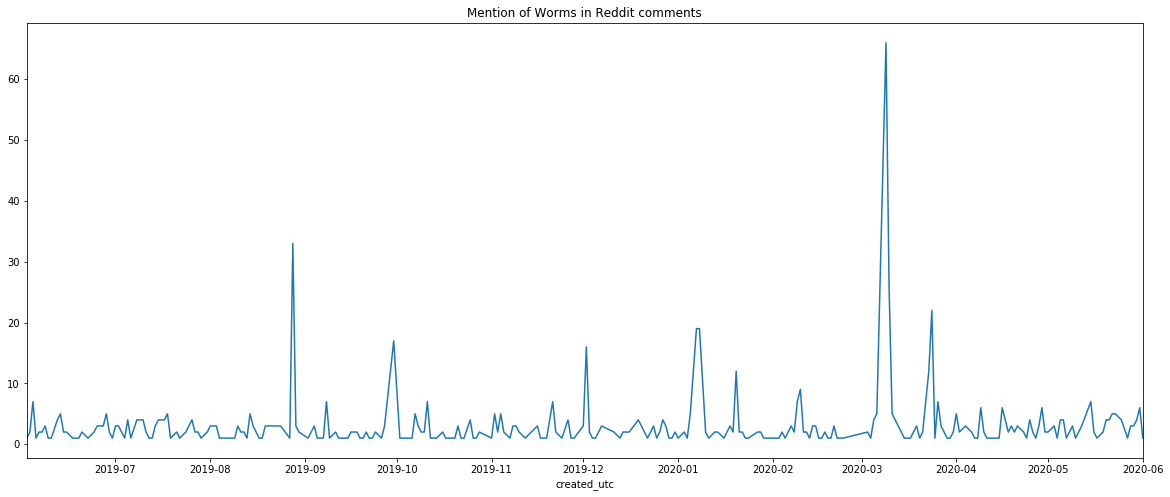

In [31]:
#visualising mentions of worms over time in the last 365 days

x = master_df1.groupby('created_utc')['body'].count()


x.plot.line(figsize=(20,8), title = 'Mention of Worms in Reddit comments')

In [32]:
#narrowing down to look into spike in mentions

startdate = pd.to_datetime("2020-03-05").date()
enddate = pd.to_datetime("2020-03-10").date()

spike_mask = (master_df1['created_utc'] > startdate) & (master_df1['created_utc'] <= enddate)

### Sentimental Analysis of comments

In [33]:
#import library to conduct sentimental analysis on comments

from textblob import TextBlob


pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity 

master_df1["Polarity"] = master_df1.iloc[:,0].apply(pol)
master_df1["Subjectivity"] = master_df1.iloc[:,0].apply(sub)

In [34]:
#dataframe demonstrating 'Polarity' (positive or negative sentiment) and 'Subjectivity' (opinion or fact)

master_df1

,body,created_utc,subreddit,Polarity,Subjectivity
1,"Worms Armageddon, strangely enough.",2019-06-02,retrogaming,0.000000,0.500000
2,Favorite Playstation game pictured: *Worms Arm...,2019-06-03,retrogaming,0.050000,0.540625
3,"Worms is a personal favorite of mine as well, ...",2019-06-03,retrogaming,0.150000,0.675000
4,"Check it out, its great. Would describe it as ...",2019-06-05,retrogaming,1.000000,0.750000
5,"""I went to this swapmeet/thriftstore/goodwill/...",2019-07-04,retrogaming,0.225000,0.325000
...,...,...,...,...,...
475,"Uh, you know Zelda oot used Mario 64's engine,...",2020-05-22,Games,0.032875,0.428388
476,It most definitely could have failed. 2D -&gt;...,2020-05-23,Games,-0.068750,0.483333
486,"Hogs of War\n\nIt was like the Worms games, bu...",2020-05-31,Games,0.029720,0.500350
487,I searched and in this entire thread you are t...,2020-05-31,Games,0.050790,0.441386


In [35]:
#statistical indicators for Polarity and Subjectivity Score

master_df1.describe()

,Polarity,Subjectivity
count,846.000000,846.000000
mean,0.090249,0.409235
std,0.237552,0.269207
min,-1.000000,0.000000
25%,0.000000,0.250000
50%,0.036667,0.458764
75%,0.204583,0.569592
max,1.000000,1.000000


Conclusion: not much is revealed here. Comments are neutral on average with a mean polarity score of 0.090249

### Collecting comments data for other Team17 games

In [36]:
#replacing 'worms' with 'automachef' in all API requests from the list of API requests from earlier in the notebook
#in short doing the same steps as before with different games

master2 = []

for url in url_list:
    url = url.replace('q=worms', "q=automachef")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master2.append(pd.DataFrame(json_data['data']))

    
master_df2 = pd.concat(master2)

In [37]:
#again for 'mugsters'

master3 = []

for url in url_list:
    url = url.replace('q=worms', "q=mugsters")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master3.append(pd.DataFrame(json_data['data']))

    
master_df3 = pd.concat(master3)

In [38]:
#again for team17

master5 = []

for url in url_list:
    url = url.replace('q=worms', "q=team17")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master5.append(pd.DataFrame(json_data['data']))

    
master_df5 = pd.concat(master5)

In [39]:
#again for 'blasphemous'

master6 = []

for url in url_list:
    url = url.replace('q=worms', "q=blasphemous")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master6.append(pd.DataFrame(json_data['data']))

    
master_df6 = pd.concat(master6)

In [40]:
#again for 'forged battalion'

master7 = []

for url in url_list:
    url = url.replace('q=worms', "q='forged battalion'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master7.append(pd.DataFrame(json_data['data']))

    
master_df7 = pd.concat(master7)

In [41]:
#again for 'planet alpha'

master8 = []

for url in url_list:
    url = url.replace('q=worms', "q='planet alpha'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master8.append(pd.DataFrame(json_data['data']))

    
master_df8 = pd.concat(master8)

In [42]:
#again for 'raging justice'

master9 = []

for url in url_list:
    url = url.replace('q=worms', "q='raging justice'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master9.append(pd.DataFrame(json_data['data']))

    
master_df9 = pd.concat(master9)

In [43]:
#etc

master11 = []

for url in url_list:
    url = url.replace('q=worms', "q='overcooked'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master11.append(pd.DataFrame(json_data['data']))

    
master_df11 = pd.concat(master11)

In [44]:
#etc

master12 = []

for url in url_list:
    url = url.replace('q=worms', "q='the survivalists'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master12.append(pd.DataFrame(json_data['data']))

    
master_df12 = pd.concat(master12)

In [45]:
#etc

master14 = []

for url in url_list:
    url = url.replace('q=worms', "q='hell let loose'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master14.append(pd.DataFrame(json_data['data']))

    
master_df14 = pd.concat(master14)

In [80]:
#making sure only capitalised mentions are included to not have irrelevant comment data 

master_df14 = master_df14[master_df14.iloc[:,0].str.contains("Hell Let Loose")]

master_df11 = master_df11[master_df11.iloc[:,0].str.contains("Overcooked")]

master_df6 = master_df6[master_df6.iloc[:,0].str.contains("Blasphemous")]


In [81]:
#combine all dataframes so have one master dataframe with data from all games 

ulimate_df = pd.concat([master_df2,master_df3,master_df5,master_df6,master_df7,master_df8, master_df9, master_df11,
         master_df12, master_df14])

In [82]:
#change date to readable format and join with original dataframe containing worms comments

ulimate_df.created_utc = pd.to_datetime(ulimate_df.iloc[:, 1], unit='s')

ulimate_df.created_utc = ulimate_df.iloc[:,1].dt.date

ulimate_df = pd.concat([master_df1, ulimate_df], sort=False)

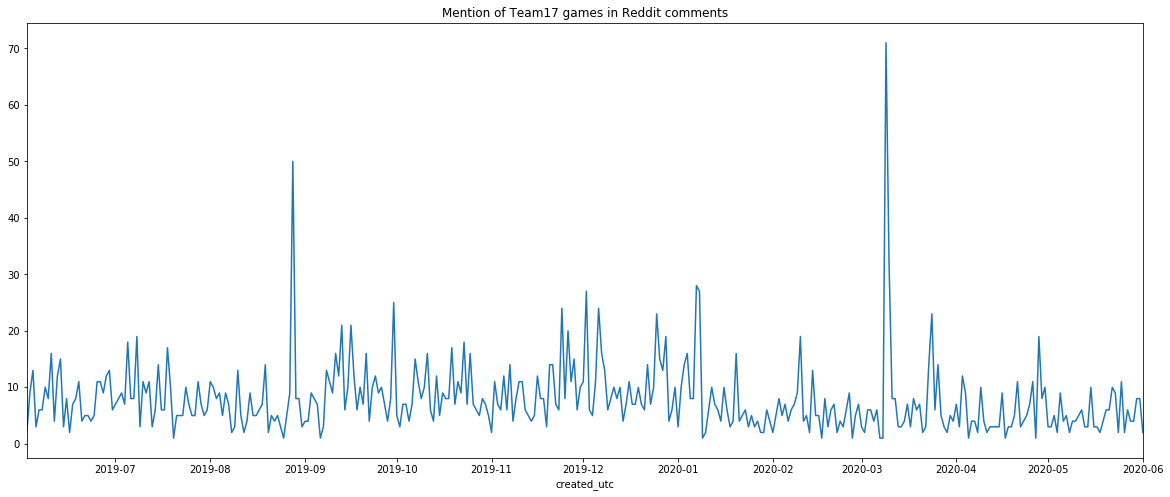

In [83]:
#visualising comments frequency in last 365 days for all (almost) Team17 games 

ulimate_df.groupby('created_utc')['body'].count().plot.line(figsize=(20,8), title = 'Mention of Team17 games in Reddit comments')


## Recent and Upcoming releases

###  Sizing up the competition - CodeMasters 

In [50]:
#same process as before but for CodeMasters recent games (released in past 1.5 years)

codemasters = []

for url in url_list:
    url = url.replace('q=worms', "q='f1 2020'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    xyz = pd.DataFrame(json_data['data'])

xyz = xyz[xyz.iloc[:,0].str.contains("F1 2020" or "f1 2020")]
codemasters.append(xyz)

In [51]:
for url in url_list:
    url = url.replace('q=worms', "q='f1 2019'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    xy = pd.DataFrame(json_data['data'])
    
xy = xy[xy.iloc[:,0].str.contains("F1 2020" or "f1 2020")]
codemasters.append(xy)

In [52]:
for url in url_list:
    url = url.replace('q=worms', "q='GRID'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    codemasters.append(pd.DataFrame(json_data['data']))

In [53]:
for url in url_list:
    url = url.replace('q=worms', "q='Grid Autosport'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    codemasters.append(pd.DataFrame(json_data['data']))

    
codemaster_df = pd.concat(codemasters)

### Team17 recent and upcoming releases - gauging hype

In [54]:
#hokko life

master16 = []

for url in url_list:
    url = url.replace('q=worms', "q='Hokko Life'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master16.append(pd.DataFrame(json_data['data']))

    
master_df16 = pd.concat(master16)

In [55]:
#Super magbot

master17 = []

for url in url_list:
    url = url.replace('q=worms', "q='Super Magbot'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master17.append(pd.DataFrame(json_data['data']))

    
master_df17 = pd.concat(master17)

In [56]:
#etc

master18 = []

for url in url_list:
    url = url.replace('q=worms', "q='Rogue Heroes'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master18.append(pd.DataFrame(json_data['data']))

    
master_df18 = pd.concat(master18)

In [57]:
#etc

master19 = []

for url in url_list:
    url = url.replace('q=worms', "q='Monster Sanctuary'")
    request = requests.get(url)
    json_data = json.loads(request.text)
    master19.append(pd.DataFrame(json_data['data']))

    
master_df19 = pd.concat(master19)

In [58]:
#concat dataframes

code17_upcoming = pd.concat([master_df14, master_df12, master_df19, master_df18, master_df17, master_df16,
                             master_df11])

In [59]:
#change data column into readable format

code17_upcoming.created_utc = pd.to_datetime(code17_upcoming.iloc[:, 1], unit='s')

code17_upcoming.created_utc = code17_upcoming.iloc[:,1].dt.date

In [60]:
#change data column into readable format

codemaster_df.created_utc = pd.to_datetime(codemaster_df.iloc[:, 1], unit='s')

codemaster_df.created_utc = codemaster_df.iloc[:,1].dt.date

In [66]:
#rename date column

code17_upcoming.rename(columns={"created_utc": "Date"}, inplace=True)

In [70]:
#rename date column

codemaster_df.rename(columns={"created_utc": "Date"}, inplace=True)

Text(0.5, 0, 'Date')

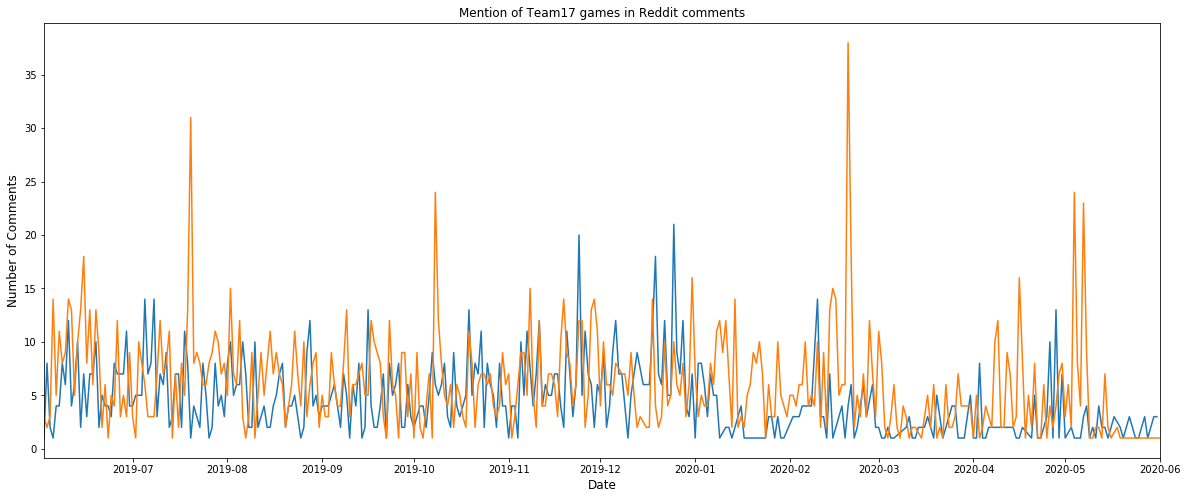

In [78]:
#plot team17 against codemasters - frequency of comments over time

ax = code17_upcoming.groupby('date')['body'].count().plot.line(figsize=(20,8),
                                                               title = 'Mention of Team17 games in Reddit comments')

codemaster_df.groupby('date')['body'].count().plot(ax=ax, y='frequency')


ax.set_ylabel("Number of Comments", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

## Conclusions

Historically the data collected indicates that CodeMqsters has enjoyed greater engagement with Reddit users. However, this gap has been closing over time with Team17 enjoying greater engagment in the last two months of 2019.